##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

The dataset is downloaded from the public docket at:
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [276]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [277]:
#Importing dataset from the github.
url = 'https://github.com/Suraj2001/CECS550-Pattern_Recognition/blob/main/HW2/Dataset/LVMPD-Stats.csv?raw=true'

orig_df = pd.read_csv(url, parse_dates=['ReportedOn'])

In [278]:
df = pd.read_csv(url, parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [279]:

df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [280]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [281]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means.
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data?


In [282]:
df.head(5)

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0


X - Latitude coordinate

Y - Longitude coordinate

Area - Likely a geographic area identifier

Command - Likely a police command area

NIBRS - Likely refers to Crime Reporting System codes

Offense Code - Type of crime committed

Day of Week - Day of week the crime occurred (1 = Monday, 2 = Tuesday, etc.)

Time - Time of day the crime occurred

Victim Count - Number of victims in the crime

###Based on the column names and data provided, the input and target variables appear to be:

**Input Variables:**

X (Longitude)

Y (Latitude)

Area

Command

NIBRS

Offense Code

Day of Week

Time

**Target Variable:**
Victim Count

The input variables provide attributes about the location, time, and type of crime committed. The target variable is the number of victims for each crime incident.

###**What is the range of values in each column? Do you need to scale, shift or normalize your data?**
Based on the sample data provided, the longitude and latitude do not need scaling, while Day of Week needs encoding, and Victim Count could potentially use scaling/normalization. More data would be needed to determine if scaling is needed for the other columns with a single sample value.



In [283]:
df.describe()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,-115.159326,36.143360,3.978182,0.909091,2.981818,11.236364,0.712727
std,0.101294,0.118418,3.045799,0.334878,1.924590,7.039937,0.978427
min,-116.000000,35.068419,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-115.209198,36.114704,1.000000,1.000000,1.000000,5.000000,0.000000
50%,-115.149945,36.152415,3.000000,1.000000,3.000000,11.000000,0.000000
75%,-115.105200,36.183854,6.000000,1.000000,5.000000,18.000000,1.000000
max,-114.625570,37.000000,11.000000,2.000000,6.000000,23.000000,6.000000


## Task 2

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

In [284]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Selecting the input features in X and target variable in y from the dataframe df.
cols = ['X', 'Y', 'Area_Command',	'NIBRSOffenseCode',	'DayOfWeek',	'Time']
X = df[cols]
y = df['VictimCount']

# Splitting the data into training and test sets using sklearn's train_test_split. 80% is allocated for training and 20% is allocated for testing.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Converting the NumPy arrays obtained from train_test_split into PyTorch Tensors.
X_train_ten = torch.tensor(X_train.values, dtype=torch.float)
y_train_ten = torch.tensor(y_train.values, dtype=torch.float)
X_test_ten =  torch.tensor(X_test.values, dtype=torch.float)
y_test_ten =  torch.tensor(y_test.values, dtype=torch.float)

# Creating TensorDataset objects to bundle the input and target tensors to create data loaders.
train_dataset = TensorDataset(X_train_ten, y_train_ten)
test_dataset = TensorDataset(X_test_ten, y_test_ten)

# Creating DataLoader objects for the training and test set to generate batched data. Used a batch size of 32.
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verifying the shape of the training data by looping.
for batch_X, batch_y in train_loader:
    print(batch_X.shape, batch_y.shape)
    break

torch.Size([32, 6]) torch.Size([32])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem.

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

In [293]:
# Hyperparameters
learning_rate = 0.001
output_size = 1 # The output is a single predicted value for number of victims. So the output size should be 1.
input_size = 6 # Number of Input features
num_epochs = 200

# Defining loss function
loss_fn = nn.MSELoss()

# Creating model architecture
model = nn.Sequential(
  nn.Linear(input_size, 32),
  nn.Sigmoid(),
  nn.Linear(32,16),
  nn.Sigmoid(),
  nn.Linear(16,8),
  nn.ReLU(),
  nn.Linear(8,4),
  nn.ReLU(),
  nn.Linear(4,2),
  nn.ReLU(),
  nn.Linear(2,1),
  nn.ReLU(),
  nn.Linear(1, output_size)
)

# Using Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
  for x_batch, y_batch in train_loader:
    # Forward pass.
    y_pred = model(x_batch)

    # Calculate loss(MSE) for training data.
    loss = loss_fn(y_pred, y_batch)

    # Backward pass.
    loss.backward()

    # Update weights.
    optimizer.step()

    #Zero the gradients after updating.
    optimizer.zero_grad()

  # Calculating test loss
  with torch.inference_mode():
    for x_test, y_test in test_loader:
          # Load images with gradient accumulation capabilities.
          x_test = x_test.requires_grad_()

          # Forward pass on test data to get predictions.
          output = model(x_test)

          # Loss for test data.
          test_loss = loss_fn(output,y_test)

  # Prints training and test loss every 10 epochs to monitor progress.
  if (epoch+1) % 10 == 0:
    print(f'Epoch: {epoch+1}, Training MSE: {loss:.3f}, Test_MSE: {test_loss:.3f}')


Epoch: 10, Training MSE: 2.528, Test_MSE: 2.345
Epoch: 20, Training MSE: 1.673, Test_MSE: 2.182
Epoch: 30, Training MSE: 1.418, Test_MSE: 2.033
Epoch: 40, Training MSE: 2.040, Test_MSE: 1.896
Epoch: 50, Training MSE: 1.933, Test_MSE: 1.771
Epoch: 60, Training MSE: 1.768, Test_MSE: 1.657
Epoch: 70, Training MSE: 2.522, Test_MSE: 1.554
Epoch: 80, Training MSE: 1.746, Test_MSE: 1.461
Epoch: 90, Training MSE: 1.311, Test_MSE: 1.376
Epoch: 100, Training MSE: 0.873, Test_MSE: 1.301
Epoch: 110, Training MSE: 1.171, Test_MSE: 1.233
Epoch: 120, Training MSE: 1.594, Test_MSE: 1.173
Epoch: 130, Training MSE: 0.805, Test_MSE: 1.119
Epoch: 140, Training MSE: 0.783, Test_MSE: 1.072
Epoch: 150, Training MSE: 1.225, Test_MSE: 1.030
Epoch: 160, Training MSE: 0.750, Test_MSE: 0.994
Epoch: 170, Training MSE: 0.966, Test_MSE: 0.962
Epoch: 180, Training MSE: 0.763, Test_MSE: 0.934
Epoch: 190, Training MSE: 0.714, Test_MSE: 0.910
Epoch: 200, Training MSE: 0.681, Test_MSE: 0.890


###**Explain your choice of architecture, including how many layers you will be using?**
I've created feedforward fully-connected neural network model using nn.Sequential with infusing linear layers along with different activation functions like ReLU and Sigmoid. In total, I've utilised 7 linear layers out of which 5 are hidden layers comprising of 2 sigmoid functions and 4 ReLU(rectified linear unit) functions.

###**Is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it**

As per the results recorded during the training phase and testing phase, one can observe that MSE tends to decrease while testing in comparision to training the model where the MSE trend is completely abnormal. I applied following changes to the model in order to increase the accuracy:

*   Kept standard learning rate because higher the rate lower the training of model.
*   Hidden layer allows the model to learn patterns from more from the train dataset, potentially leading to better outputs. For a the same reason, I increased the number of hidden layers.
*   Using ReLU as a hidden layer activation function and Sigmoid as output activation function for such kind of regression problem, the learning rate of model improved drastically.



## Task 4

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem.

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

In [295]:
from torch.nn.modules.activation import Softmax
# Hyperparameters
learning_rate = 0.001
num_classes = len(df['VictimCount'].unique())
input_size = 6
num_epochs = 100

# Define loss function
loss_fn1 = nn.CrossEntropyLoss()

# Define model architecture
classification_model = nn.Sequential(
  nn.Linear(input_size, 12),
  nn.Linear(12, num_classes)
)

# Define optimizer
optimizer = torch.optim.Adam(classification_model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):

  for x_batch, y_batch in train_loader:
    # Forward pass
    y_pred = classification_model(x_batch)

    # Calculate loss
    loss = loss_fn1(y_pred, y_batch.long())

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    #Zero the gradients after updating
    optimizer.zero_grad()


  # Calculate test loss
  with torch.no_grad():
    correct = 0
    total = 0
    accuracy = 0
    for x_test, y_test in test_loader:
          # Load images with gradient accumulation capabilities
          x_test = x_test.requires_grad_()

          # Forward pass on test data to get predictions.
          outputs = classification_model(x_test)

          test_loss = loss_fn1(outputs,y_test.long())
          # Get predictions from the maximum value
          _, predicted = torch.max(outputs.data, 1)

          # Total number of labels
          total += y_test.size(0)

          # Total correct predictions
          correct += (predicted == y_test).sum()

          Curr_accuracy = 100 * correct / total

  if (epoch+1) % 10 == 0:
    print(f'Epoch: {epoch+1}, Loss: {test_loss}, Accuracy: {Curr_accuracy}')


Epoch: 10, Loss: 3.2418339252471924, Accuracy: 52.727272033691406
Epoch: 20, Loss: 1.5198966264724731, Accuracy: 49.09090805053711
Epoch: 30, Loss: 1.3205968141555786, Accuracy: 50.90909194946289
Epoch: 40, Loss: 1.2581565380096436, Accuracy: 49.09090805053711
Epoch: 50, Loss: 1.202976942062378, Accuracy: 50.90909194946289
Epoch: 60, Loss: 1.167077898979187, Accuracy: 52.727272033691406
Epoch: 70, Loss: 1.1630598306655884, Accuracy: 50.90909194946289
Epoch: 80, Loss: 1.1390653848648071, Accuracy: 50.90909194946289
Epoch: 90, Loss: 1.1340179443359375, Accuracy: 54.54545593261719
Epoch: 100, Loss: 1.1374683380126953, Accuracy: 58.181819915771484


###**Differences observed in comparision to regression task.**
Some of noticable changes observed in classification are listed as below:

* Generally for classification models we use softmax as output activation function and cross entropy loss  as loss function.
* Using number of classes as output because we're predicting the range of victims rather than predicting single value for number of victims.
* Calculating accuracy rather than finding MSE.



###**How would you find the number of classes on the output data?**
Number of classes can be obtained by finding unique values in the column victim count of the given dataframe.

###**How is the architecture different?**
As compared to regression task, the only difference in the architecture can be seen at the output of layer and the output activation function. We are using number of classes as output and softmax as output activation function. However, the accuracy of the model became constant when using the activation function, so I didn't made use of that.

###**How is the loss function different?**
For classification, we typically use cross-entropy loss or negative log likelihood loss. These include:
* nn.CrossEntropyLoss()

These losses expect the model output to be log probabilities for each class. The target is a integer. Cross entropy calculates the probability error between the predicted and true distributions. It measures how well the model predicts the true distribution.

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

Task 3 was a regression problem of predicting the exact values of victim count whereas, Task 4 seemed to be easy as to generate a class of victim count. Model architecture was similar in both the problems except the output activation function and the output layer. Moreover, regression was all about reducing the MSE while classification focused on increasing the accuracy of the model. Overall, I gained a better understanding of models under different tasks while tunning the hyperparameter for best learning rate.

###**How do you compare the results? Which one worked better? Why?**
While the classification strategy discretizes the values into classes, the regression approach predicts the number of victims directly. The classification strategy performed better, probably because it is easier to categorize the problem into classes rather than to anticipate the exact count, which is a challenging task to predict.

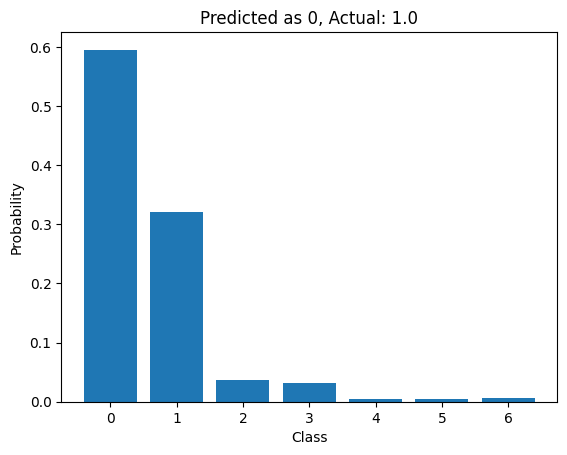

In [288]:
with torch.no_grad():
    # Find and visualize a misclassification
    for x_test, y_test in test_loader:
        test_logits = classification_model(x_test)
        probabilities = torch.softmax(test_logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        incorrect_indices = (predicted_class != y_test).nonzero()

        for idx in incorrect_indices:
            sample_data = x_test[idx].unsqueeze(0)  # Get the misclassified example
            sample_target = y_test[idx]  # Correct target label
            predicted_target = predicted_class[idx]  # Predicted target label
            probabilities_for_sample = probabilities[idx]

            # Plotting the bar chart for probabilities
            classes = np.arange(probabilities_for_sample.size(1))
            plt.bar(classes, probabilities_for_sample.squeeze().numpy())
            plt.xlabel('Class')
            plt.ylabel('Probability')
            plt.xticks(classes)
            plt.title(f'Predicted as {predicted_target.item()}, Actual: {sample_target.item()}')
            plt.show()
            break  # Break after showing one misclassification
        break  # Break after checking one batc

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


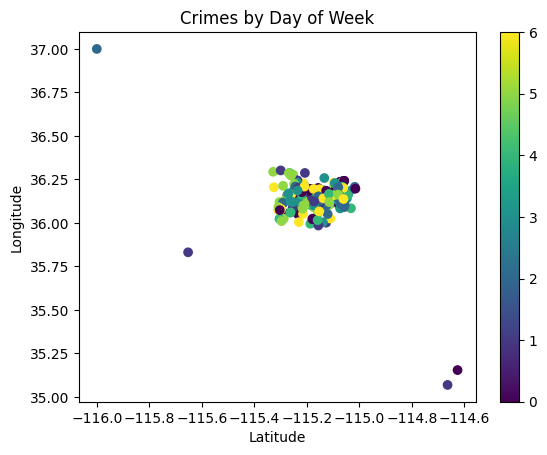

In [289]:
# Scatter plot with color as day of week
plt.scatter(df['X'], df['Y'], c=df['DayOfWeek'])
plt.colorbar()
plt.title("Crimes by Day of Week")
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

Upon examining, it is evident that while there are a few outliers, the majority of victims and crime scenes occurred inside a specific area, the data is not dispersed, and the majority of crimes are committed on weekends.

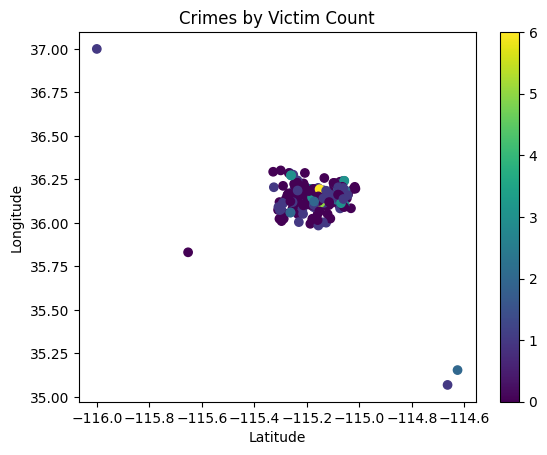

In [290]:
# Scatter plot with color as victim count
plt.scatter(df['X'], df['Y'], c=df['VictimCount'])
plt.colorbar()
plt.title("Crimes by Victim Count")
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

There aren't many outliers, but the majority of victims and crime scenes occurred in a specific area, with a higher concentration of 3 or 4 average victims in the specific area.

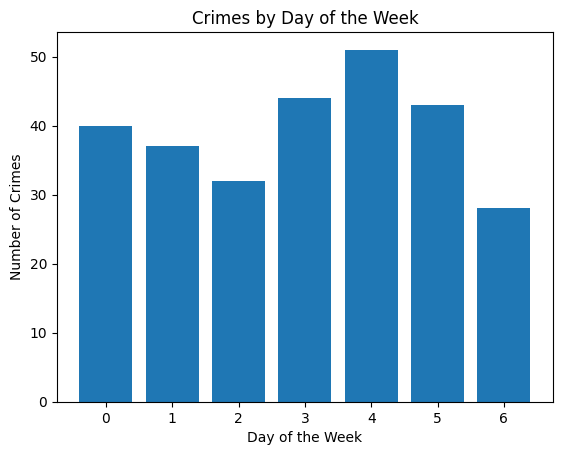


The most frequent day for crimes is: 4


In [291]:
# Sorting days by the frequency
days = df['DayOfWeek'].value_counts().index
counts = df['DayOfWeek'].value_counts().values
plt.bar(days, counts)
plt.xticks(days)
plt.title("Crimes by Day of the Week")
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')
plt.show()

# Display the day with the maximum crimes.
highest_crime_day = days[0]
print(f"\nThe most frequent day for crimes is: {highest_crime_day}")

##**References:**

* https://github.com/elswit/Fall-23-APML-Public/blob/main/Tutorials/Deep-Learning-Basics.ipynb
* https://github.com/mrdbourke/pytorch-deep-learning/blob/main/docs/02_pytorch_classification.ipynb